# ECON 570 Assignment 2

# Tian Luo

# 1668149405

In [1]:
import graphviz as gr

import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

from helperfunction import fn_generate_cov
from helperfunction import fn_bias_rmse_size
from helperfunction import fn_randomize_treatment
from helperfunction import fn_generate_multnorm

# Part 1 Experiments with covariates

$y_i = \tau*T_i+\beta'*x_i+e_i$  


In [2]:
def fn_generate_data(tau,N,p,corr,flagX = False):
    nvar = p+2 # 1 confounder and variable for randomizing treatment
        
    allX = fn_generate_multnorm(N,corr,nvar)
    X = allX[:,2:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    Yab = tau*T+X@beta0+err
    
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

In [3]:
tau = 5 # True value of treatment effect
N = 1000 # Sample size
p = 10
corr = .5 # Correlations between covariates
flagX = True

In [4]:
dataCovariates = fn_generate_data(tau,N,p,corr,flagX)
Y = pd.DataFrame(dataCovariates[0])
T = pd.DataFrame(dataCovariates[1])
X = pd.DataFrame(dataCovariates[2])

dataCovariates = pd.concat([Y,T,X],axis=1)
dataCovariates.columns = ['Y','T','X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']
dataCovariates.to_csv('DataCovariates.csv')

In [5]:
dataCovariates

,Y,T,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,26.452569,0,-0.109774,0.795465,1.083525,1.045872,0.539501,0.779062,-0.057461,-0.523835,1.088212,0.089642
1,11.429083,0,0.735848,0.486729,0.698397,0.254363,0.545261,0.233394,-0.158439,2.403287,-0.511045,1.327463
2,5.483441,1,-0.174675,0.010959,-0.729063,0.130056,0.439516,-0.181925,-0.684181,-0.844175,0.489683,-0.751876
3,-11.010488,0,-0.636156,0.760288,0.390177,-0.826199,-1.497019,0.308123,-1.213391,-1.326912,-0.666116,-1.310329
4,-0.439424,1,-0.869732,-0.488105,0.641261,-0.429678,0.008205,0.687974,0.359027,-0.465557,-0.090826,0.526191
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-9.436633,1,-0.525178,-0.667452,-0.164158,-0.453618,-0.775188,-0.481573,-0.989839,0.776649,-0.486200,-0.065985
996,-44.268220,1,0.027327,-1.344104,0.198760,-1.614113,-0.900050,-0.878879,0.165426,-0.609655,-1.999429,-0.765831
997,-0.051498,1,0.665122,-0.312037,2.269252,-0.642319,0.453176,0.128102,1.389696,1.805787,0.359677,0.396498
998,-42.195058,1,-0.231492,-0.325911,-1.431843,-3.040280,-3.349133,-1.122103,-1.711273,-0.357253,-0.073706,-2.334433


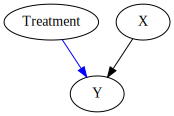

In [6]:
g = gr.Digraph()
g.edge("Treatment", "Y",color = 'Blue'),
g.edge("X" ,"Y")

g

# Q1(a) Not control convariates



In [7]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,corr,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
        res = model.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 127.77it/s]


In [8]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.030442120950853566, RMSE=8.181990473850574, size=0.053
N=1000: bias=0.03309478513620002, RMSE=2.5531887610236046, size=0.0525


# Q1(b) Control covariates

In [9]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,corr,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1))
        res = model.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 122.48it/s]


In [10]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.011471254975491382, RMSE=0.21187947008467145, size=0.057
N=1000: bias=-0.0016522660769428675, RMSE=0.06314573109463568, size=0.0515


# Real-life example:

The relationship between changes in Federal Funds rate and Nasdaq Index, here:

Treatment = Changes in Federal Funds rate

Y = Nasdaq Index

There are other factors which could affect the Nasdaq Index except the treatment:

Covariates = Consumption Index, GDP, Unemplyment rate 


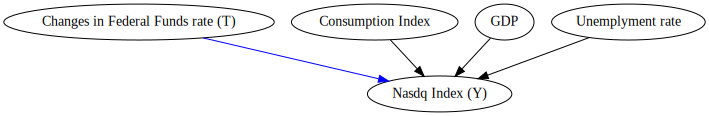

In [11]:
g = gr.Digraph()
g.edge("Changes in Federal Funds rate (T)", "Nasdq Index (Y)",color = 'Blue'),
g.edge("Consumption Index" ,"Nasdq Index (Y)")
g.edge("GDP" ,"Nasdq Index (Y)")
g.edge("Unemplyment rate" ,"Nasdq Index (Y)")

g

   # Part 2 Experiments with confounders

$y_i = \tau*T_i+\beta'*Confounder_i+e_i$

$T_i = \beta''*Confounder_i+u_i$

In [12]:
def fn_generate_data_Confounder(tau,N,p,corr,conf = True):
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5
    conf_mult = 1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    
    return (Yab,T,C)
    

In [13]:
tau = 5 # True value of treatment effect
N = 1000 # Sample size
p = 10
corr = .5 # Correlations between covariates
conf = True # A confounder

In [14]:
dataConfounder = fn_generate_data_Confounder(tau,N,p,corr,conf)
Y = pd.DataFrame(dataConfounder[0])
T = pd.DataFrame(dataConfounder[1])
C = pd.DataFrame(dataConfounder[2])

dataConfounder = pd.concat([Y,T,C],axis=1)
dataConfounder.columns = ['Y','T','Confounder']
dataConfounder.to_csv('DataConfounder.csv')

In [15]:
dataConfounder

,Y,T,Confounder
0,14.496935,1,-0.952882
1,-82.259262,1,-1.542284
2,120.337104,0,1.056606
3,-138.885811,1,-2.104821
4,-2.978613,1,0.072919
...,...,...,...
995,-5.746661,0,-0.530152
996,-53.245341,1,-1.061932
997,-75.418071,0,-0.921930
998,-80.382821,0,-1.416811


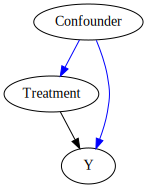

In [16]:
g=gr.Digraph()
g.node("Treatment")
g.edge("Confounder","Treatment",color ='Blue')
g.edge("Confounder","Y",color ='Blue')
g.edge("Treatment","Y")

g

# Q2(a) Not control the confounder

In [17]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,C = fn_generate_data_Confounder(tau,N,p,corr)
        model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
        res = model.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 135.40it/s]


In [18]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.13529262593156777, RMSE=8.028169227033256, size=0.0565
N=1000: bias=0.05184684027909032, RMSE=2.590669593646137, size=0.048


# Q2(b) Control the confounder

In [19]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,C = fn_generate_data_Confounder(tau,N,p,corr)
        model = sm.OLS(Yexp,np.concatenate([T,C,const],axis = 1))
        res = model.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 133.84it/s]


In [20]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.22169073841469247, RMSE=6.120111082207049, size=0.0575
N=1000: bias=-0.03551648860168177, RMSE=1.9599953884226615, size=0.051


# Real-life example:
The relationship between annual salary and education, here:

Treatment = Whether go to college

Y = Annual salary

The IQ will affect the people's education and people will higher intelligence are more likely to get into colleges. Besides, people will higher IQ are also more likely to achieve higher pay in their work. Thus.

Confounder = IQ

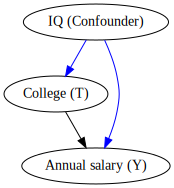

In [21]:
g=gr.Digraph()
g.node("College (T)")
g.edge("IQ (Confounder)","College (T)",color ='Blue')
g.edge("IQ (Confounder)","Annual salary (Y)",color ='Blue')
g.edge("College (T)","Annual salary (Y)")

g

# Experiments with selection bias

$y_i = \tau*T_i+e_i$

$Selection bias =\beta'*T_i+\beta''*y_i+u_i$


In [22]:
def fn_generate_data_Selectionbias(tau,N,p,corr,conf = True):
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5
    conf_mult = 1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    urr = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    beta1 = np.random.normal(3,3,[N,1])
    beta2 = np.random.normal(3,3,[N,1])
    
   
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    Selectionbias = beta1*T+beta2*Yab+urr
    
    return (Yab,T,Selectionbias)

In [23]:
tau = 5 # True value of treatment effect
N = 1000 # Sample size
p = 10
corr = .5 # Correlations between covariates
conf = False # No confounder

In [24]:
dataSelectionbias = fn_generate_data_Selectionbias(tau,N,p,corr,conf)
Y = pd.DataFrame(dataSelectionbias[0])
T = pd.DataFrame(dataSelectionbias[1])
S = pd.DataFrame(dataSelectionbias[2])

dataSelectionbias = pd.concat([Y,T,S],axis=1)
dataSelectionbias.columns = ['Y','T','Selectionbias']
dataSelectionbias.to_csv('Selectionbias.csv')

In [25]:
dataSelectionbias

,Y,T,Selectionbias
0,-6.521223,0,-24.231755
1,-14.167899,1,-15.010644
2,26.353283,1,54.389675
3,-12.047034,1,-61.116881
4,-24.959879,1,-81.102765
...,...,...,...
995,3.732550,0,3.365642
996,24.149994,0,165.398285
997,58.129166,0,470.652342
998,20.011804,1,159.741803


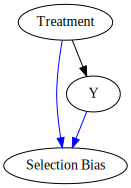

In [26]:
g=gr.Digraph()
g.node("Treatment")
g.edge("Treatment","Selection Bias",color ='Blue')
g.edge("Y","Selection Bias",color ='Blue')
g.edge("Treatment","Y")

g

# Q3(a) Not control Selection Bias

In [27]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,S = fn_generate_data_Selectionbias(tau,N,p,corr,conf)
        model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
        res = model.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:16<00:00, 119.23it/s]


In [28]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.1310506516362871, RMSE=8.208389695439358, size=0.0535
N=1000: bias=0.10867200433824961, RMSE=2.592427150801818, size=0.058


# Q3(b) Control selection bias

In [29]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    const = np.ones([N,1])
    for r in tqdm(range(R)):
        Yexp,T,S = fn_generate_data_Selectionbias(tau,N,p,corr,conf)
        model = sm.OLS(Yexp,np.concatenate([T,S,const],axis = 1))
        res = model.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 125.46it/s]


In [30]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-2.946603321069355, RMSE=6.707603140121555, size=0.124
N=1000: bias=-2.950103010489211, RMSE=3.4527172850302645, size=0.4655


# Real-life example:
In the relationship between family income and intellegence, here:

Treatment = Family income

Y = IQ

Since students with higher family income and intelligence are more likely to get into universities, if we choose the univeristy students as sample observations, samples will not be randomly selected and biased. Thus:

Selectionbias = Whether go to univerisities

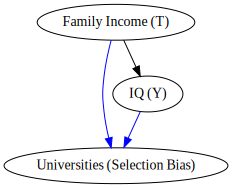

In [31]:
g=gr.Digraph()
g.node("Family Income (T)")
g.edge("Family Income (T)","Universities (Selection Bias)",color ='Blue')
g.edge("IQ (Y)","Universities (Selection Bias)",color ='Blue')
g.edge("Family Income (T)","IQ (Y)")

g